In [2]:
import healpy as hp
from astropy.io import fits
import numpy as np
import treecorr
import sys, os
sys.path.append('/mnt/home/spandey/ceph/esutil/esutil')
# import esutil.coords
import coords
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl






In [3]:
# len(M200m_websky)
def ang2eq(theta, phi):
    ra = phi * 180. / np.pi
    dec = 90. - theta * 180. / np.pi
    return ra, dec


def eq2ang(ra, dec):
    phi = ra * np.pi / 180.
    theta = (np.pi / 2.) - dec * (np.pi / 180.)
    return theta, phi

def get_zmean(zcent,delz,nz_bin):
    prob_zcent = nz_bin
    zmean = (np.sum(prob_zcent*zcent*delz))/(np.sum(prob_zcent*delz))
    return zmean




In [66]:
ldir = '/mnt/home/spandey/ceph/agora/'
ksz_noiseless = hp.read_map(ldir + 'ksz/mdpl2_lkszNG_bahamas76_rot_sum_4_176_bnd_unb_1.0e+12_1.0e+18_v103021_lmax24000_nside8192_interp1.6_method1_1_lensed_map.fits')
ksz_noiseless = hp.ud_grade(ksz_noiseless, 2048)
ksz = ksz_noiseless
npix_ksz = len(ksz)
nside_ksz = hp.npix2nside(npix_ksz)
pix_theta, pix_phi = hp.pix2ang(nside_ksz, np.arange(npix_ksz))
pix_ra, pix_dec = ang2eq(pix_theta, pix_phi)






In [67]:
do_jk = True
put_weights_datapoints = True
do_randy_sub = True
nthreads = 128
bin_slop = 0.05

minrad = 1.0
maxrad = 30.0    
nrad = 15
njk = 4096


In [6]:
lgM_min = 14.0
lgM_max = 16.0
M_min = 10**lgM_min
M_max = 10**lgM_max
# z_min = 0.2
# z_max = 0.5
z_min_array = np.array([0.0, 0.25, 0.5, 0.75])
z_max_array = np.array([0.25, 0.5, 0.75, 1.0])


In [7]:
import pickle as pk

for jz in range(len(z_min_array)):
    z_min = z_min_array[jz]
    z_max = z_max_array[jz]
    print(z_min, z_max)
    all_ind = np.arange(0,176)
    # all_ind
    zall, vall, mall, ra_all, dec_all = [], [], [], [], []
    from tqdm import tqdm
    for ji in tqdm(range(len(all_ind))):
        try:
            df = np.load(ldir + 'halolc/haloslc_rot_' + str(ji+1) + '.npy')
            if np.any(df[:,2] < z_min):
                pass
            elif np.any(df[:,2] > z_max):
                break
            else:
                m200c = df[:,3]
                indsel = np.where((m200c > M_min) & (m200c < M_max))[0]
                zsel = df[:,2][indsel]
                vsel = df[:,7][indsel]
                rasel = df[:,0][indsel]
                decsel = df[:,1][indsel]   
                msel = m200c[indsel]
                zall.append(zsel)
                vall.append(vsel)
                ra_all.append(rasel)
                dec_all.append(decsel)
                mall.append(msel)
        except:
            pass
    zall = np.hstack((zall))
    mall = np.hstack((mall))
    vall = np.hstack((vall))

    datapoint_ra, datapoint_dec = np.hstack((ra_all)), np.hstack((dec_all))
    datapoint_w = np.ones_like(datapoint_ra)
    nrand = 5*len(datapoint_ra)
    rand_ra, rand_dec = coords.randsphere(nrand, ra_range=[0,360], dec_range=[-90,90])
    rand_w = np.ones_like(rand_ra)

    import sys, os
    save_dir_jk = '/mnt/home/spandey/ceph/SZST/temp/'
    save_filename_jk_obj = 'temp_jk_centers_njk' + str(njk)
    if os.path.isfile(save_dir_jk + save_filename_jk_obj):
        datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                    dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)           

    else:
        datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                        dec_units='degrees', npatch=njk)
        datapoint_cat.write_patch_centers(save_dir_jk + save_filename_jk_obj)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, w=rand_w, ra_units='degrees', dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)

    # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
    ytruth_cat = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz, ra_units='degrees', dec_units='degrees')

    dytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
    randytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

    print('doing orig dataxy calculation')
    dytruth.process(datapoint_cat, ytruth_cat)

    # print('doing orig randomxy calculation')
    randytruth.process(rand_cat, ytruth_cat)
    dytruth.calculateXi(rk=randytruth)

    xi_dy_full = dytruth.xi
    r_dy = np.exp(dytruth.meanlogr)
    cov_dy = dytruth.cov
    sig_dy = np.sqrt(np.diag(cov_dy))
    snr_orig = (np.sqrt(np.dot(xi_dy_full, np.dot(np.linalg.inv(cov_dy), xi_dy_full))))

    # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
    ytruth_cat2 = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz**2, ra_units='degrees', dec_units='degrees')

    dytruth2 = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
    randytruth2 = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

    print('doing sq dataxy calculation')
    dytruth2.process(datapoint_cat, ytruth_cat2)

    # print('doing sq randomxy calculation')
    randytruth2.process(rand_cat, ytruth_cat2)
    dytruth2.calculateXi(rk=randytruth2)

    xi_dy_full2 = dytruth2.xi
    r_dy2 = np.exp(dytruth2.meanlogr)
    cov_dy2 = dytruth2.cov
    sig_dy2 = np.sqrt(np.diag(cov_dy2))

    snr_sq = (np.sqrt(np.dot(xi_dy_full2, np.dot(np.linalg.inv(cov_dy2), xi_dy_full2))))
        
    # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
    ytruth_cat_abs = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=np.abs(ksz), ra_units='degrees', dec_units='degrees')

    dytruth_abs = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
    randytruth_abs = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

    print('doing abs dataxy calculation')
    dytruth_abs.process(datapoint_cat, ytruth_cat_abs)

    # print('doing abs randomxy calculation')
    randytruth_abs.process(rand_cat, ytruth_cat_abs)
    dytruth_abs.calculateXi(rk=randytruth_abs)

    xi_dy_full_abs = dytruth_abs.xi
    r_dy_abs = np.exp(dytruth_abs.meanlogr)
    cov_dy_abs = dytruth_abs.cov
    sig_dy_abs = np.sqrt(np.diag(cov_dy_abs))

    snr_abs = (np.sqrt(np.dot(xi_dy_full_abs, np.dot(np.linalg.inv(cov_dy_abs), xi_dy_full_abs))))

    print('snr_orig, snr_sq, snr_abs', snr_orig, snr_sq, snr_abs)

    saved_all = {'ntot':len(datapoint_ra) ,'xi_dy_full':xi_dy_full, 'r_dy':r_dy, 'cov_dy':cov_dy, 'sig_dy':sig_dy, 'snr_orig':snr_orig, 'xi_dy_full2':xi_dy_full2, 'r_dy2':r_dy2, 'cov_dy2':cov_dy2, 'sig_dy2':sig_dy2, 'snr_sq':snr_sq, 'xi_dy_full_abs':xi_dy_full_abs, 'r_dy_abs':r_dy_abs, 'cov_dy_abs':cov_dy_abs, 'sig_dy_abs':sig_dy_abs, 'snr_abs':snr_abs}

    saved_fname = '/mnt/home/spandey/ceph/SZST/results/' + 'ksz_noiseless_xi_results_njk_' + str(njk) + '_dict_z_' + str(z_min) + '_' + str(z_max) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk'
    pk.dump(saved_all, open(saved_fname, 'wb'))


0.0 0.25


 15%|█▌        | 27/176 [00:04<00:23,  6.30it/s]


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
snr_orig, snr_sq, snr_abs 5.564086014992066 22.729359026890293 54.29331624363402
0.25 0.5


 29%|██▉       | 51/176 [00:09<00:23,  5.42it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
snr_orig, snr_sq, snr_abs 6.935351319855067 39.00556541342976 88.21486384531867
0.5 0.75


 41%|████      | 72/176 [00:12<00:18,  5.54it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
snr_orig, snr_sq, snr_abs 2.621158344817386 41.612045928731895 94.89480512932145
0.75 1.0


 52%|█████▏    | 91/176 [00:17<00:15,  5.33it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
snr_orig, snr_sq, snr_abs 3.7500624499409287 49.206777753357585 98.15813443647971


In [8]:
# lgM_min_array = np.array([13.0, 13.5, 14.0, 15.0])
# lgM_max_array = np.array([13.5, 14.0, 15.0, 16.0])
# lgM_min_array = np.array([12.5, 12.75, 14.0])
# lgM_max_array = np.array([12.75, 13.0, 16.0])
lgM_min_array = np.array([12.5, 12.75, 13.0, 13.5, 14.0])
lgM_max_array = np.array([12.75, 13.0, 13.5, 14.0, 16.0])

# z_min = 0.25
# z_max = 0.5

z_min = 0.5
z_max = 0.75

# z_min_array = np.array([0.0, 0.25, 0.5, 0.75])
# z_max_array = np.array([0.25, 0.5, 0.75, 1.0])


In [9]:
import pickle as pk

for jz in range(len(lgM_min_array)):
    lgM_min = lgM_min_array[jz]
    lgM_max = lgM_max_array[jz]
    M_min = 10**lgM_min
    M_max = 10**lgM_max    
    print(lgM_min, lgM_max)
    all_ind = np.arange(0,176)
    # all_ind
    zall, vall, mall, ra_all, dec_all = [], [], [], [], []
    from tqdm import tqdm
    for ji in tqdm(range(len(all_ind))):
        try:
            df = np.load(ldir + 'halolc/haloslc_rot_' + str(ji+1) + '.npy')
            if np.any(df[:,2] < z_min):
                pass
            elif np.any(df[:,2] > z_max):
                break
            else:
                m200c = df[:,3]
                indsel = np.where((m200c > M_min) & (m200c < M_max))[0]
                zsel = df[:,2][indsel]
                vsel = df[:,7][indsel]
                rasel = df[:,0][indsel]
                decsel = df[:,1][indsel]   
                msel = m200c[indsel]
                zall.append(zsel)
                vall.append(vsel)
                ra_all.append(rasel)
                dec_all.append(decsel)
                mall.append(msel)
        except:
            pass
    zall = np.hstack((zall))
    mall = np.hstack((mall))
    vall = np.hstack((vall))

    datapoint_ra, datapoint_dec = np.hstack((ra_all)), np.hstack((dec_all))
    datapoint_w = np.ones_like(datapoint_ra)
    nrand = 5*len(datapoint_ra)
    rand_ra, rand_dec = coords.randsphere(nrand, ra_range=[0,360], dec_range=[-90,90])
    rand_w = np.ones_like(rand_ra)

    import sys, os
    save_dir_jk = '/mnt/home/spandey/ceph/SZST/temp/'
    save_filename_jk_obj = 'temp_jk_centers_njk' + str(njk)
    if os.path.isfile(save_dir_jk + save_filename_jk_obj):
        datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                    dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)           

    else:
        datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                        dec_units='degrees', npatch=njk)
        datapoint_cat.write_patch_centers(save_dir_jk + save_filename_jk_obj)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, w=rand_w, ra_units='degrees', dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)

    # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
    ytruth_cat = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz, ra_units='degrees', dec_units='degrees')

    dytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
    randytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

    print('doing orig dataxy calculation')
    dytruth.process(datapoint_cat, ytruth_cat)

    # print('doing orig randomxy calculation')
    randytruth.process(rand_cat, ytruth_cat)
    dytruth.calculateXi(rk=randytruth)

    xi_dy_full = dytruth.xi
    r_dy = np.exp(dytruth.meanlogr)
    cov_dy = dytruth.cov
    sig_dy = np.sqrt(np.diag(cov_dy))
    snr_orig = (np.sqrt(np.dot(xi_dy_full, np.dot(np.linalg.inv(cov_dy), xi_dy_full))))

    # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
    ytruth_cat2 = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz**2, ra_units='degrees', dec_units='degrees')

    dytruth2 = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
    randytruth2 = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

    print('doing sq dataxy calculation')
    dytruth2.process(datapoint_cat, ytruth_cat2)

    # print('doing sq randomxy calculation')
    randytruth2.process(rand_cat, ytruth_cat2)
    dytruth2.calculateXi(rk=randytruth2)

    xi_dy_full2 = dytruth2.xi
    r_dy2 = np.exp(dytruth2.meanlogr)
    cov_dy2 = dytruth2.cov
    sig_dy2 = np.sqrt(np.diag(cov_dy2))

    snr_sq = (np.sqrt(np.dot(xi_dy_full2, np.dot(np.linalg.inv(cov_dy2), xi_dy_full2))))
        
    # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
    ytruth_cat_abs = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=np.abs(ksz), ra_units='degrees', dec_units='degrees')

    dytruth_abs = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
    randytruth_abs = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

    print('doing abs dataxy calculation')
    dytruth_abs.process(datapoint_cat, ytruth_cat_abs)

    # print('doing abs randomxy calculation')
    randytruth_abs.process(rand_cat, ytruth_cat_abs)
    dytruth_abs.calculateXi(rk=randytruth_abs)

    xi_dy_full_abs = dytruth_abs.xi
    r_dy_abs = np.exp(dytruth_abs.meanlogr)
    cov_dy_abs = dytruth_abs.cov
    sig_dy_abs = np.sqrt(np.diag(cov_dy_abs))

    snr_abs = (np.sqrt(np.dot(xi_dy_full_abs, np.dot(np.linalg.inv(cov_dy_abs), xi_dy_full_abs))))



    saved_all = {'ntot':len(datapoint_ra) ,'xi_dy_full':xi_dy_full, 'r_dy':r_dy, 'cov_dy':cov_dy, 'sig_dy':sig_dy, 'snr_orig':snr_orig, 'xi_dy_full2':xi_dy_full2, 'r_dy2':r_dy2, 'cov_dy2':cov_dy2, 'sig_dy2':sig_dy2, 'snr_sq':snr_sq, 'xi_dy_full_abs':xi_dy_full_abs, 'r_dy_abs':r_dy_abs, 'cov_dy_abs':cov_dy_abs, 'sig_dy_abs':sig_dy_abs, 'snr_abs':snr_abs}
    print('ntot:',len(datapoint_ra))
    print('snr_orig, snr_sq, snr_abs', snr_orig, snr_sq, snr_abs)

    saved_fname = '/mnt/home/spandey/ceph/SZST/results/' + 'ksz_noiseless_xi_results_njk_' + str(njk) + '_dict_z_' + str(z_min) + '_' + str(z_max) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk'
    pk.dump(saved_all, open(saved_fname, 'wb'))




12.5 12.75


 41%|████      | 72/176 [00:15<00:23,  4.50it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
ntot: 8518432
snr_orig, snr_sq, snr_abs 4.881126146728331 27.53744165279287 57.7299552584684
12.75 13.0


 41%|████      | 72/176 [00:03<00:04, 22.69it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
ntot: 4648613
snr_orig, snr_sq, snr_abs 2.788024312792785 27.667536702317 59.666640697931335
13.0 13.5


 41%|████      | 72/176 [00:03<00:04, 23.71it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
ntot: 3647181
snr_orig, snr_sq, snr_abs 4.350370267689042 34.622181543880664 79.47885770087888
13.5 14.0


 41%|████      | 72/176 [00:02<00:04, 25.47it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
ntot: 793094
snr_orig, snr_sq, snr_abs 3.589053416531547 44.0316386807855 104.33594484069668
14.0 16.0


 41%|████      | 72/176 [00:02<00:04, 25.68it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
ntot: 111601
snr_orig, snr_sq, snr_abs 2.200156586756889 41.868762055755795 94.77999567826107


In [12]:
# lgM_min_array = np.array([12.5, 12.75, 13.0, 13.5, 14.0])
# lgM_max_array = np.array([12.75, 13.0, 13.5, 14.0, 16.0])

# z_min = 0.25
# z_max = 0.5

# lgM_min = 13.5
# lgM_max = 14.0

lgM_min = 14.0
lgM_max = 16.0

M_min = 10**lgM_min
M_max = 10**lgM_max

z_min = 0.5
z_max = 0.75

noise_std_level_array = np.array([1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0])


In [13]:
import pickle as pk

for jz in range(len(noise_std_level_array)):
    # lgM_min = lgM_min_array[jz]
    # lgM_max = lgM_max_array[jz]
    # M_min = 10**lgM_min
    # M_max = 10**lgM_max   
    noise_std_jz = noise_std_level_array[jz] 

    ksz_noise = np.random.randn(len(ksz_noiseless)) * (noise_std_jz*np.std(ksz_noiseless))
    ksz = ksz_noiseless + ksz_noise


    print(noise_std_jz)
    all_ind = np.arange(0,176)
    # all_ind
    zall, vall, mall, ra_all, dec_all = [], [], [], [], []
    from tqdm import tqdm
    for ji in tqdm(range(len(all_ind))):
        try:
            df = np.load(ldir + 'halolc/haloslc_rot_' + str(ji+1) + '.npy')
            if np.any(df[:,2] < z_min):
                pass
            elif np.any(df[:,2] > z_max):
                break
            else:
                m200c = df[:,3]
                indsel = np.where((m200c > M_min) & (m200c < M_max))[0]
                zsel = df[:,2][indsel]
                vsel = df[:,7][indsel]
                rasel = df[:,0][indsel]
                decsel = df[:,1][indsel]   
                msel = m200c[indsel]
                zall.append(zsel)
                vall.append(vsel)
                ra_all.append(rasel)
                dec_all.append(decsel)
                mall.append(msel)
        except:
            pass
    zall = np.hstack((zall))
    mall = np.hstack((mall))
    vall = np.hstack((vall))

    datapoint_ra, datapoint_dec = np.hstack((ra_all)), np.hstack((dec_all))
    datapoint_w = np.ones_like(datapoint_ra)
    nrand = 5*len(datapoint_ra)
    rand_ra, rand_dec = coords.randsphere(nrand, ra_range=[0,360], dec_range=[-90,90])
    rand_w = np.ones_like(rand_ra)

    import sys, os
    save_dir_jk = '/mnt/home/spandey/ceph/SZST/temp/'
    save_filename_jk_obj = 'temp_jk_centers_njk' + str(njk)
    if os.path.isfile(save_dir_jk + save_filename_jk_obj):
        datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                    dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)           

    else:
        datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                        dec_units='degrees', npatch=njk)
        datapoint_cat.write_patch_centers(save_dir_jk + save_filename_jk_obj)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, w=rand_w, ra_units='degrees', dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)

    # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
    ytruth_cat = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz, ra_units='degrees', dec_units='degrees')

    dytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
    randytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

    print('doing orig dataxy calculation')
    dytruth.process(datapoint_cat, ytruth_cat)

    # print('doing orig randomxy calculation')
    randytruth.process(rand_cat, ytruth_cat)
    dytruth.calculateXi(rk=randytruth)

    xi_dy_full = dytruth.xi
    r_dy = np.exp(dytruth.meanlogr)
    cov_dy = dytruth.cov
    sig_dy = np.sqrt(np.diag(cov_dy))
    snr_orig = (np.sqrt(np.dot(xi_dy_full, np.dot(np.linalg.inv(cov_dy), xi_dy_full))))

    # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
    ytruth_cat2 = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz**2, ra_units='degrees', dec_units='degrees')

    dytruth2 = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
    randytruth2 = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

    print('doing sq dataxy calculation')
    dytruth2.process(datapoint_cat, ytruth_cat2)

    # print('doing sq randomxy calculation')
    randytruth2.process(rand_cat, ytruth_cat2)
    dytruth2.calculateXi(rk=randytruth2)

    xi_dy_full2 = dytruth2.xi
    r_dy2 = np.exp(dytruth2.meanlogr)
    cov_dy2 = dytruth2.cov
    sig_dy2 = np.sqrt(np.diag(cov_dy2))

    snr_sq = (np.sqrt(np.dot(xi_dy_full2, np.dot(np.linalg.inv(cov_dy2), xi_dy_full2))))
        
    # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
    ytruth_cat_abs = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=np.abs(ksz), ra_units='degrees', dec_units='degrees')

    dytruth_abs = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
    randytruth_abs = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

    print('doing abs dataxy calculation')
    dytruth_abs.process(datapoint_cat, ytruth_cat_abs)

    # print('doing abs randomxy calculation')
    randytruth_abs.process(rand_cat, ytruth_cat_abs)
    dytruth_abs.calculateXi(rk=randytruth_abs)

    xi_dy_full_abs = dytruth_abs.xi
    r_dy_abs = np.exp(dytruth_abs.meanlogr)
    cov_dy_abs = dytruth_abs.cov
    sig_dy_abs = np.sqrt(np.diag(cov_dy_abs))

    snr_abs = (np.sqrt(np.dot(xi_dy_full_abs, np.dot(np.linalg.inv(cov_dy_abs), xi_dy_full_abs))))



    saved_all = {'ntot':len(datapoint_ra) ,'xi_dy_full':xi_dy_full, 'r_dy':r_dy, 'cov_dy':cov_dy, 'sig_dy':sig_dy, 'snr_orig':snr_orig, 'xi_dy_full2':xi_dy_full2, 'r_dy2':r_dy2, 'cov_dy2':cov_dy2, 'sig_dy2':sig_dy2, 'snr_sq':snr_sq, 'xi_dy_full_abs':xi_dy_full_abs, 'r_dy_abs':r_dy_abs, 'cov_dy_abs':cov_dy_abs, 'sig_dy_abs':sig_dy_abs, 'snr_abs':snr_abs}
    print('ntot:',len(datapoint_ra))
    print('snr_orig, snr_sq, snr_abs', snr_orig, snr_sq, snr_abs)

    saved_fname = '/mnt/home/spandey/ceph/SZST/results/' + 'ksz_noisefac_' + str(noise_std_jz) + 'sigma_xi_results_njk_' + str(njk) + '_dict_z_' + str(z_min) + '_' + str(z_max) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk'
    pk.dump(saved_all, open(saved_fname, 'wb'))




1.0


 41%|████      | 72/176 [00:03<00:04, 23.73it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
ntot: 111601
snr_orig, snr_sq, snr_abs 3.209999116719119 40.5144612503862 75.48203757906316
2.0


 41%|████      | 72/176 [00:02<00:04, 24.52it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
ntot: 111601
snr_orig, snr_sq, snr_abs 3.453454374901767 38.32819502584921 57.45226058895973
5.0


 41%|████      | 72/176 [00:02<00:04, 25.94it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
ntot: 111601
snr_orig, snr_sq, snr_abs 4.31130727030614 26.149857054480364 27.71690207758204
10.0


 41%|████      | 72/176 [00:03<00:04, 23.96it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
ntot: 111601
snr_orig, snr_sq, snr_abs 5.027041683497668 11.868378097111227 10.950044297243148
20.0


 41%|████      | 72/176 [00:02<00:04, 25.60it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
ntot: 111601
snr_orig, snr_sq, snr_abs 3.3967910162386588 5.582073851237178 5.4336783312936445
50.0


 41%|████      | 72/176 [00:02<00:04, 25.86it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
ntot: 111601
snr_orig, snr_sq, snr_abs 3.721335520187429 4.214117136106605 3.9586832009701673
100.0


 41%|████      | 72/176 [00:03<00:04, 22.40it/s] 


doing orig dataxy calculation
doing sq dataxy calculation
doing abs dataxy calculation
ntot: 111601
snr_orig, snr_sq, snr_abs 3.4022593581365856 2.974321763128768 2.807608199455837


In [5]:
lgM_min = 14.0
lgM_max = 16.0

M_min = 10**lgM_min
M_max = 10**lgM_max

z_min = 0.5
z_max = 0.75

a_array = np.array([0.2, 0.5, 1.0, 2.0, 5.0])
b_array = np.array([0.2, 0.5, 1.0, 2.0, 5.0])



In [7]:
import pickle as pk

for ja in range(len(a_array)):
    for jb in range(len(b_array)):
        a_ja = a_array[ja]
        b_jb = b_array[jb]
        print('a_ja, b_jb', a_ja, b_jb)
        ksz = np.abs(ksz_noiseless) + a_ja * (ksz_noiseless**2) + b_jb * (ksz_noiseless**2) * np.abs(ksz_noiseless)


        # print(noise_std_jz)
        all_ind = np.arange(0,176)
        # all_ind
        zall, vall, mall, ra_all, dec_all = [], [], [], [], []
        from tqdm import tqdm
        for ji in tqdm(range(len(all_ind))):
            try:
                df = np.load(ldir + 'halolc/haloslc_rot_' + str(ji+1) + '.npy')
                if np.any(df[:,2] < z_min):
                    pass
                elif np.any(df[:,2] > z_max):
                    break
                else:
                    m200c = df[:,3]
                    indsel = np.where((m200c > M_min) & (m200c < M_max))[0]
                    zsel = df[:,2][indsel]
                    vsel = df[:,7][indsel]
                    rasel = df[:,0][indsel]
                    decsel = df[:,1][indsel]   
                    msel = m200c[indsel]
                    zall.append(zsel)
                    vall.append(vsel)
                    ra_all.append(rasel)
                    dec_all.append(decsel)
                    mall.append(msel)
            except:
                pass
        zall = np.hstack((zall))
        mall = np.hstack((mall))
        vall = np.hstack((vall))

        datapoint_ra, datapoint_dec = np.hstack((ra_all)), np.hstack((dec_all))
        datapoint_w = np.ones_like(datapoint_ra)
        nrand = 5*len(datapoint_ra)
        rand_ra, rand_dec = coords.randsphere(nrand, ra_range=[0,360], dec_range=[-90,90])
        rand_w = np.ones_like(rand_ra)

        import sys, os
        save_dir_jk = '/mnt/home/spandey/ceph/SZST/temp/'
        save_filename_jk_obj = 'temp_jk_centers_njk' + str(njk)
        if os.path.isfile(save_dir_jk + save_filename_jk_obj):
            datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                        dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)           

        else:
            datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                            dec_units='degrees', npatch=njk)
            datapoint_cat.write_patch_centers(save_dir_jk + save_filename_jk_obj)
        rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, w=rand_w, ra_units='degrees', dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)

        # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
        ytruth_cat = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz, ra_units='degrees', dec_units='degrees')

        dytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
        randytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

        print('doing orig dataxy calculation')
        dytruth.process(datapoint_cat, ytruth_cat)

        # print('doing orig randomxy calculation')
        randytruth.process(rand_cat, ytruth_cat)
        dytruth.calculateXi(rk=randytruth)

        xi_dy_full = dytruth.xi
        r_dy = np.exp(dytruth.meanlogr)
        cov_dy = dytruth.cov
        sig_dy = np.sqrt(np.diag(cov_dy))
        snr_orig = (np.sqrt(np.dot(xi_dy_full, np.dot(np.linalg.inv(cov_dy), xi_dy_full))))

        saved_all = {'ntot':len(datapoint_ra) ,'xi_dy_full':xi_dy_full, 'r_dy':r_dy, 'cov_dy':cov_dy, 'sig_dy':sig_dy, 'snr_orig':snr_orig, 'a':a_ja, 'b':b_jb}
        print('ntot:',len(datapoint_ra))
        # print('snr_orig, snr_sq, snr_abs', snr_orig, snr_sq, snr_abs)
        print('snr_orig', snr_orig)

        saved_fname = '/mnt/home/spandey/ceph/SZST/results/' + 'ksz_noiseless_comb_a_' + str(a_ja) + '_b_' + str(b_jb) + '_xi_results_njk_' + str(njk) + '_dict_z_' + str(z_min) + '_' + str(z_max) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk'
        pk.dump(saved_all, open(saved_fname, 'wb'))




a_ja, b_jb 0.2 0.2


 41%|████      | 72/176 [00:26<00:38,  2.72it/s]


doing orig dataxy calculation
ntot: 111601
snr_orig 19.080603623925263
a_ja, b_jb 0.2 0.5


 41%|████      | 72/176 [00:03<00:05, 20.03it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 18.925932546537513
a_ja, b_jb 0.2 1.0


 41%|████      | 72/176 [00:03<00:04, 21.14it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 18.60082890490291
a_ja, b_jb 0.2 2.0


 41%|████      | 72/176 [00:02<00:04, 25.19it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 18.915027157843394
a_ja, b_jb 0.2 5.0


 41%|████      | 72/176 [00:02<00:04, 24.44it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 18.522424127318473
a_ja, b_jb 0.5 0.2


 41%|████      | 72/176 [00:02<00:04, 25.31it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 20.1584579773909
a_ja, b_jb 0.5 0.5


 41%|████      | 72/176 [00:02<00:04, 24.77it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 19.266514081471207
a_ja, b_jb 0.5 1.0


 41%|████      | 72/176 [00:02<00:04, 25.37it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 18.90014573229389
a_ja, b_jb 0.5 2.0


 41%|████      | 72/176 [00:02<00:04, 25.15it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 19.133207679952143
a_ja, b_jb 0.5 5.0


 41%|████      | 72/176 [00:02<00:04, 24.51it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 18.732530855601205
a_ja, b_jb 1.0 0.2


 41%|████      | 72/176 [00:02<00:04, 24.22it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 21.641111017830816
a_ja, b_jb 1.0 0.5


 41%|████      | 72/176 [00:02<00:04, 25.27it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 19.48625985938141
a_ja, b_jb 1.0 1.0


 41%|████      | 72/176 [00:02<00:04, 25.47it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 19.2842459389012
a_ja, b_jb 1.0 2.0


 41%|████      | 72/176 [00:02<00:04, 24.48it/s] 


doing orig dataxy calculation


KeyboardInterrupt: 

In [10]:
lgM_min = 14.0
lgM_max = 16.0

M_min = 10**lgM_min
M_max = 10**lgM_max

z_min = 0.5
z_max = 0.75

# pow_array = np.array([0.1, 0.2, 0.5, 0.75])
pow_array = np.array([0.001, 0.005, 0.01, 0.05])



In [11]:
import pickle as pk

for ja in range(len(pow_array)):
    # for jb in range(len(b_array)):
    pow_ja = pow_array[ja]

    print('pow_ja', pow_ja)
    ksz = np.abs(ksz_noiseless)**pow_ja


    # print(noise_std_jz)
    all_ind = np.arange(0,176)
    # all_ind
    zall, vall, mall, ra_all, dec_all = [], [], [], [], []
    from tqdm import tqdm
    for ji in tqdm(range(len(all_ind))):
        try:
            df = np.load(ldir + 'halolc/haloslc_rot_' + str(ji+1) + '.npy')
            if np.any(df[:,2] < z_min):
                pass
            elif np.any(df[:,2] > z_max):
                break
            else:
                m200c = df[:,3]
                indsel = np.where((m200c > M_min) & (m200c < M_max))[0]
                zsel = df[:,2][indsel]
                vsel = df[:,7][indsel]
                rasel = df[:,0][indsel]
                decsel = df[:,1][indsel]   
                msel = m200c[indsel]
                zall.append(zsel)
                vall.append(vsel)
                ra_all.append(rasel)
                dec_all.append(decsel)
                mall.append(msel)
        except:
            pass
    zall = np.hstack((zall))
    mall = np.hstack((mall))
    vall = np.hstack((vall))

    datapoint_ra, datapoint_dec = np.hstack((ra_all)), np.hstack((dec_all))
    datapoint_w = np.ones_like(datapoint_ra)
    nrand = 5*len(datapoint_ra)
    rand_ra, rand_dec = coords.randsphere(nrand, ra_range=[0,360], dec_range=[-90,90])
    rand_w = np.ones_like(rand_ra)

    import sys, os
    save_dir_jk = '/mnt/home/spandey/ceph/SZST/temp/'
    save_filename_jk_obj = 'temp_jk_centers_njk' + str(njk)
    if os.path.isfile(save_dir_jk + save_filename_jk_obj):
        datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                    dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)           

    else:
        datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                        dec_units='degrees', npatch=njk)
        datapoint_cat.write_patch_centers(save_dir_jk + save_filename_jk_obj)
    rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, w=rand_w, ra_units='degrees', dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)

    # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
    ytruth_cat = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz, ra_units='degrees', dec_units='degrees')

    dytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
    randytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

    print('doing orig dataxy calculation')
    dytruth.process(datapoint_cat, ytruth_cat)

    # print('doing orig randomxy calculation')
    randytruth.process(rand_cat, ytruth_cat)
    dytruth.calculateXi(rk=randytruth)

    xi_dy_full = dytruth.xi
    r_dy = np.exp(dytruth.meanlogr)
    cov_dy = dytruth.cov
    sig_dy = np.sqrt(np.diag(cov_dy))
    snr_orig = (np.sqrt(np.dot(xi_dy_full, np.dot(np.linalg.inv(cov_dy), xi_dy_full))))

    saved_all = {'ntot':len(datapoint_ra) ,'xi_dy_full':xi_dy_full, 'r_dy':r_dy, 'cov_dy':cov_dy, 'sig_dy':sig_dy, 'snr_orig':snr_orig, 'a':a_ja, 'b':b_jb}
    print('ntot:',len(datapoint_ra))
    # print('snr_orig, snr_sq, snr_abs', snr_orig, snr_sq, snr_abs)
    print('snr_orig', snr_orig)

    saved_fname = '/mnt/home/spandey/ceph/SZST/results/' + 'ksz_noiseless_abspow_' + str(pow_ja) + '_xi_results_njk_' + str(njk) + '_dict_z_' + str(z_min) + '_' + str(z_max) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk'
    pk.dump(saved_all, open(saved_fname, 'wb'))




pow_ja 0.001


 41%|████      | 72/176 [00:02<00:04, 24.34it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 149.98855656436965
pow_ja 0.005


 41%|████      | 72/176 [00:02<00:04, 24.91it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 150.2308837801599
pow_ja 0.01


 41%|████      | 72/176 [00:02<00:04, 25.37it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 151.3873238204505
pow_ja 0.05


 41%|████      | 72/176 [00:02<00:04, 25.11it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 150.85066008128467


In [69]:
# lgM_min_array = np.array([12.5, 12.75, 13.0, 13.5, 14.0])
# lgM_max_array = np.array([12.75, 13.0, 13.5, 14.0, 16.0])

# z_min = 0.25
# z_max = 0.5

# lgM_min = 13.5
# lgM_max = 14.0

lgM_min = 14.0
lgM_max = 16.0

M_min = 10**lgM_min
M_max = 10**lgM_max

z_min = 0.5
z_max = 0.75

# noise_std_level_array = np.array([1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0])
noise_std_level_array = np.array([1.0, 2.0, 5.0, 10.0])


In [70]:
import pickle as pk
# pow_ja = 0.1
pow_array = np.array([0.5, 1.0, 1.2, 1.5, 2.0, 3.0])
for pow_ja in pow_array:
    print('pow_ja', pow_ja)
    for jz in range(len(noise_std_level_array)):
        # lgM_min = lgM_min_array[jz]
        # lgM_max = lgM_max_array[jz]
        # M_min = 10**lgM_min
        # M_max = 10**lgM_max   
        noise_std_jz = noise_std_level_array[jz] 

        ksz_noise = np.random.randn(len(ksz_noiseless)) * (noise_std_jz*np.std(ksz_noiseless))
        ksz = ksz_noiseless + ksz_noise
        ksz = np.abs(ksz)**pow_ja


        print(noise_std_jz)
        all_ind = np.arange(0,176)
        # all_ind
        zall, vall, mall, ra_all, dec_all = [], [], [], [], []
        from tqdm import tqdm
        for ji in tqdm(range(len(all_ind))):
            try:
                df = np.load(ldir + 'halolc/haloslc_rot_' + str(ji+1) + '.npy')
                if np.any(df[:,2] < z_min):
                    pass
                elif np.any(df[:,2] > z_max):
                    break
                else:
                    m200c = df[:,3]
                    indsel = np.where((m200c > M_min) & (m200c < M_max))[0]
                    zsel = df[:,2][indsel]
                    vsel = df[:,7][indsel]
                    rasel = df[:,0][indsel]
                    decsel = df[:,1][indsel]   
                    msel = m200c[indsel]
                    zall.append(zsel)
                    vall.append(vsel)
                    ra_all.append(rasel)
                    dec_all.append(decsel)
                    mall.append(msel)
            except:
                pass
        zall = np.hstack((zall))
        mall = np.hstack((mall))
        vall = np.hstack((vall))

        datapoint_ra, datapoint_dec = np.hstack((ra_all)), np.hstack((dec_all))
        datapoint_w = np.ones_like(datapoint_ra)
        nrand = 5*len(datapoint_ra)
        rand_ra, rand_dec = coords.randsphere(nrand, ra_range=[0,360], dec_range=[-90,90])
        rand_w = np.ones_like(rand_ra)

        import sys, os
        save_dir_jk = '/mnt/home/spandey/ceph/SZST/temp/'
        save_filename_jk_obj = 'temp_jk_centers_njk' + str(njk)
        if os.path.isfile(save_dir_jk + save_filename_jk_obj):
            datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                        dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)           

        else:
            datapoint_cat = treecorr.Catalog(ra=datapoint_ra, dec=datapoint_dec, w=datapoint_w, ra_units='degrees',
                                            dec_units='degrees', npatch=njk)
            datapoint_cat.write_patch_centers(save_dir_jk + save_filename_jk_obj)
        rand_cat = treecorr.Catalog(ra=rand_ra, dec=rand_dec, w=rand_w, ra_units='degrees', dec_units='degrees', patch_centers=save_dir_jk + save_filename_jk_obj)

        # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
        ytruth_cat = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz, ra_units='degrees', dec_units='degrees')

        dytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
        randytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

        print('doing orig dataxy calculation')
        dytruth.process(datapoint_cat, ytruth_cat)

        # print('doing orig randomxy calculation')
        randytruth.process(rand_cat, ytruth_cat)
        dytruth.calculateXi(rk=randytruth)

        xi_dy_full = dytruth.xi
        r_dy = np.exp(dytruth.meanlogr)
        cov_dy = dytruth.cov
        sig_dy = np.sqrt(np.diag(cov_dy))
        snr_orig = (np.sqrt(np.dot(xi_dy_full, np.dot(np.linalg.inv(cov_dy), xi_dy_full))))

        # # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
        # ytruth_cat2 = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz**2, ra_units='degrees', dec_units='degrees')

        # dytruth2 = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
        # randytruth2 = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

        # print('doing sq dataxy calculation')
        # dytruth2.process(datapoint_cat, ytruth_cat2)

        # # print('doing sq randomxy calculation')
        # randytruth2.process(rand_cat, ytruth_cat2)
        # dytruth2.calculateXi(rk=randytruth2)

        # xi_dy_full2 = dytruth2.xi
        # r_dy2 = np.exp(dytruth2.meanlogr)
        # cov_dy2 = dytruth2.cov
        # sig_dy2 = np.sqrt(np.diag(cov_dy2))

        # snr_sq = (np.sqrt(np.dot(xi_dy_full2, np.dot(np.linalg.inv(cov_dy2), xi_dy_full2))))
            
        # # ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
        # ytruth_cat_abs = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=np.abs(ksz), ra_units='degrees', dec_units='degrees')

        # dytruth_abs = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
        # randytruth_abs = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

        # print('doing abs dataxy calculation')
        # dytruth_abs.process(datapoint_cat, ytruth_cat_abs)

        # # print('doing abs randomxy calculation')
        # randytruth_abs.process(rand_cat, ytruth_cat_abs)
        # dytruth_abs.calculateXi(rk=randytruth_abs)

        # xi_dy_full_abs = dytruth_abs.xi
        # r_dy_abs = np.exp(dytruth_abs.meanlogr)
        # cov_dy_abs = dytruth_abs.cov
        # sig_dy_abs = np.sqrt(np.diag(cov_dy_abs))

        # snr_abs = (np.sqrt(np.dot(xi_dy_full_abs, np.dot(np.linalg.inv(cov_dy_abs), xi_dy_full_abs))))



        saved_all = {'ntot':len(datapoint_ra) ,'xi_dy_full':xi_dy_full, 'r_dy':r_dy, 'cov_dy':cov_dy, 'sig_dy':sig_dy, 'snr_orig':snr_orig}
        print('ntot:',len(datapoint_ra))
        print('snr_orig', snr_orig)

        saved_fname = '/mnt/home/spandey/ceph/SZST/results/' + 'ksz_abspow_' + str(pow_ja) + '_noisefac_' + str(noise_std_jz) + 'sigma_xi_results_njk_' + str(njk) + '_dict_z_' + str(z_min) + '_' + str(z_max) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk'
        pk.dump(saved_all, open(saved_fname, 'wb'))




pow_ja 0.5
1.0


 41%|████      | 72/176 [00:24<00:34,  2.98it/s]


doing orig dataxy calculation
ntot: 111601
snr_orig 92.21567179161778
2.0


 41%|████      | 72/176 [00:03<00:05, 20.23it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 61.558516347538294
5.0


 41%|████      | 72/176 [00:03<00:04, 21.10it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 25.561333700420175
10.0


 41%|████      | 72/176 [00:02<00:03, 27.30it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 7.207573668466964
pow_ja 1.0
1.0


 41%|████      | 72/176 [00:02<00:03, 27.23it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 76.75942704830571
2.0


 41%|████      | 72/176 [00:03<00:04, 22.57it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 59.031003491683315
5.0


 41%|████      | 72/176 [00:03<00:04, 21.69it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 26.34121281355898
10.0


 41%|████      | 72/176 [00:03<00:04, 22.23it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 10.742904298655391
pow_ja 1.2
1.0


 41%|████      | 72/176 [00:25<00:36,  2.86it/s]


doing orig dataxy calculation
ntot: 111601
snr_orig 70.3183388433047
2.0


 41%|████      | 72/176 [00:02<00:04, 24.70it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 55.123813201253455
5.0


 41%|████      | 72/176 [00:02<00:04, 25.13it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 26.608070300508597
10.0


 41%|████      | 72/176 [00:25<00:36,  2.87it/s]


doing orig dataxy calculation
ntot: 111601
snr_orig 9.668388832315221
pow_ja 1.5
1.0


 41%|████      | 72/176 [00:03<00:04, 23.51it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 57.95159305009442
2.0


 41%|████      | 72/176 [00:22<00:33,  3.14it/s]


doing orig dataxy calculation
ntot: 111601
snr_orig 47.999322600099845
5.0


 41%|████      | 72/176 [00:21<00:30,  3.41it/s]


doing orig dataxy calculation
ntot: 111601
snr_orig 25.76844184558483
10.0


 41%|████      | 72/176 [00:02<00:04, 24.08it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 10.742665123171019
pow_ja 2.0
1.0


 41%|████      | 72/176 [00:02<00:04, 25.18it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 40.596237177817024
2.0


 41%|████      | 72/176 [00:03<00:04, 23.88it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 37.554432274009336
5.0


 41%|████      | 72/176 [00:02<00:04, 25.95it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 24.88373565406806
10.0


 41%|████      | 72/176 [00:02<00:04, 25.50it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 10.636844833989105
pow_ja 3.0
1.0


 41%|████      | 72/176 [00:02<00:03, 26.52it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 20.068851252056444
2.0


 41%|████      | 72/176 [00:02<00:04, 25.99it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 21.66528837116968
5.0


 41%|████      | 72/176 [00:03<00:04, 22.44it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 20.048251819435595
10.0


 41%|████      | 72/176 [00:02<00:04, 24.84it/s] 


doing orig dataxy calculation
ntot: 111601
snr_orig 9.643675795205825


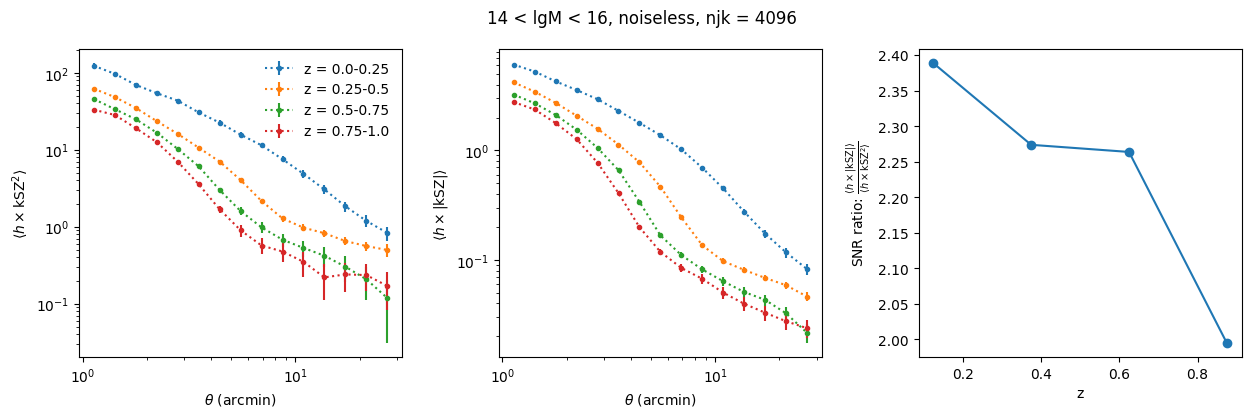

In [9]:
# plot the results
# plot variantons with redshift bins. Make a 3 panel plot with left panel showing xi_dy_full2 and center panel showing xi_dy_abs and right panel showing the SNR full2/abs:
import pickle as pk
z_min_array = np.array([0.0, 0.25, 0.5, 0.75])
z_max_array = np.array([0.25, 0.5, 0.75, 1.0])
z_cen_array = (z_min_array + z_max_array)/2.0
ldir = '/mnt/home/spandey/ceph/SZST/results/'
# fig, ax_all = pl.subplots(3,1, figsize=(6,18))
fig, ax_all = pl.subplots(1,3, figsize=(15,4))
fig.subplots_adjust(wspace=0.3)
snr_ratio = np.zeros(len(z_min_array))
for jz in range(len(z_min_array)):
    zmin = z_min_array[jz]
    zmax = z_max_array[jz]
    df = pk.load(open(ldir + 'ksz_noiseless_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_14.0_16.0.pk','rb')) 
    ax_all[0].errorbar(df['r_dy2'], df['xi_dy_full2'], yerr=df['sig_dy2'], ls=':', ms=3.0, marker='o', label='z = ' + str(zmin) + '-' + str(zmax))
    ax_all[1].errorbar(df['r_dy_abs'], df['xi_dy_full_abs'], yerr=df['sig_dy_abs'], ms=3.0, ls=':', marker='o', label='z = ' + str(zmin) + '-' + str(zmax))
    snr_ratio[jz] = df['snr_abs']/df['snr_sq']
    ax_all[0].set_xscale('log')
    ax_all[1].set_xscale('log')
    ax_all[0].set_yscale('log')
    ax_all[1].set_yscale('log')
    ax_all[0].set_xlabel(r'$\theta$ (arcmin)')
    ax_all[1].set_xlabel(r'$\theta$ (arcmin)')
    ax_all[0].set_ylabel(r'$\langle h \times {\rm kSZ}^2 \rangle$')
    ax_all[1].set_ylabel(r'$\langle h \times |{\rm kSZ}| \rangle$')
ax_all[0].legend(frameon=False)
# ax_all[0].set_title('14 < lgM < 16, noiseless, njk = 4096')
fig.suptitle('14 < lgM < 16, noiseless, njk = 4096')
ax_all[2].plot(z_cen_array, snr_ratio, 'o-')
ax_all[2].set_xlabel('z')
ax_all[2].set_ylabel(r'SNR ratio: $\frac{\langle h \times |{\rm kSZ}| \rangle}{\langle h \times {\rm kSZ}^2 \rangle}$')
fig.savefig('/mnt/home/spandey/ceph/SZST/results/REDSHIFT_VARY_ksz_noiseless_xi_results_njk_4096_dict_lgM_14.0_16.0.png', bbox_inches='tight')


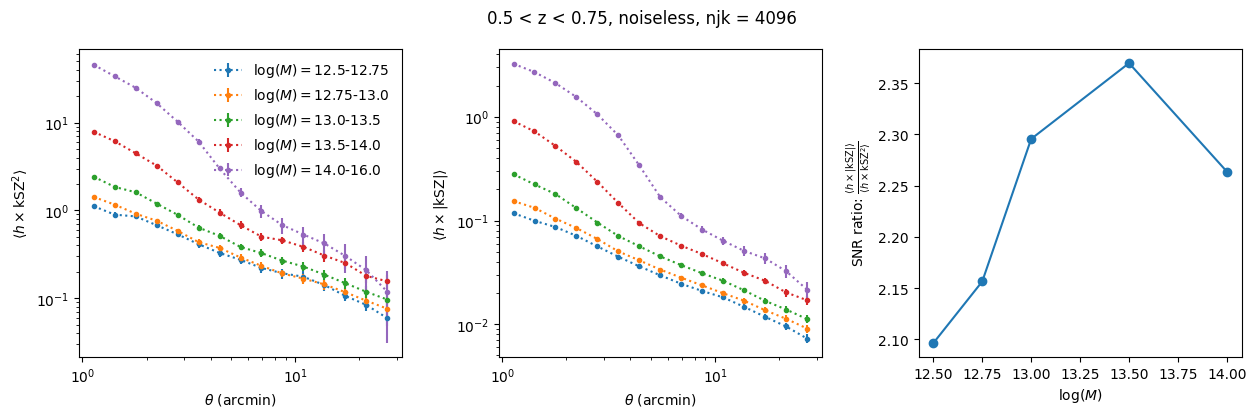

In [10]:
# plot the results
# plot variantons with mass bins. Make a 3 panel plot with left panel showing xi_dy_full2 and center panel showing xi_dy_abs and right panel showing the SNR full2/abs:
import pickle as pk
lgM_min_array = np.array([12.5, 12.75, 13.0, 13.5, 14.0])
lgM_max_array = np.array([12.75, 13.0, 13.5, 14.0, 16.0])
zmin = 0.5
zmax = 0.75
lgM_cen_array = (lgM_min_array + lgM_min_array)/2.0
ldir = '/mnt/home/spandey/ceph/SZST/results/'
# fig, ax_all = pl.subplots(3,1, figsize=(6,18))
fig, ax_all = pl.subplots(1,3, figsize=(15,4))
fig.subplots_adjust(wspace=0.3)

snr_ratio = np.zeros(len(lgM_min_array))
for jz in range(len(lgM_min_array)):
    lgM_min = lgM_min_array[jz]
    lgM_max = lgM_max_array[jz]    
    df = pk.load(open(ldir + 'ksz_noiseless_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
    ax_all[0].errorbar(df['r_dy2'], df['xi_dy_full2'], yerr=df['sig_dy2'], ls=':', ms=3.0, marker='o', label=r'$\log(M) = $' + str(lgM_min) + '-' + str(lgM_max))
    ax_all[1].errorbar(df['r_dy_abs'], df['xi_dy_full_abs'], yerr=df['sig_dy_abs'], ms=3.0, ls=':', marker='o', label=r'$\log(M) = $' + str(lgM_min) + '-' + str(lgM_max))
    snr_ratio[jz] = df['snr_abs']/df['snr_sq']
    ax_all[0].set_xscale('log')
    ax_all[1].set_xscale('log')
    ax_all[0].set_yscale('log')
    ax_all[1].set_yscale('log')
    ax_all[0].set_xlabel(r'$\theta$ (arcmin)')
    ax_all[1].set_xlabel(r'$\theta$ (arcmin)')
    ax_all[0].set_ylabel(r'$\langle h \times {\rm kSZ}^2 \rangle$')
    ax_all[1].set_ylabel(r'$\langle h \times |{\rm kSZ}| \rangle$')
ax_all[0].legend(frameon=False)
# ax_all[0].set_title('0.5 < z < 0.75, noiseless, njk = 4096')
fig.suptitle('0.5 < z < 0.75, noiseless, njk = 4096')
ax_all[2].plot(lgM_cen_array, snr_ratio, 'o-')
ax_all[2].set_xlabel(r'$\log(M)$')
ax_all[2].set_ylabel(r'SNR ratio: $\frac{\langle h \times |{\rm kSZ}| \rangle}{\langle h \times {\rm kSZ}^2 \rangle}$')
fig.savefig('/mnt/home/spandey/ceph/SZST/results/MASS_VARY_ksz_noiseless_xi_results_njk_4096_dict_z_0.5_0.75.png', bbox_inches='tight')


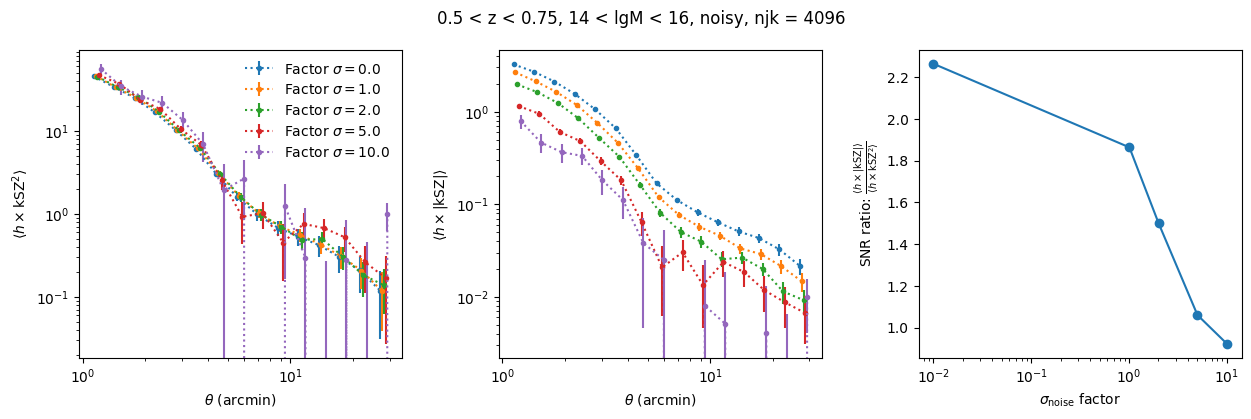

In [17]:
# plot the results
# plot variantons with noise factor. Make a 3 panel plot with left panel showing xi_dy_full2 and center panel showing xi_dy_abs and right panel showing the SNR full2/abs:
import pickle as pk
lgM_min = 14.0
lgM_max = 16.0
zmin = 0.5
zmax = 0.75

noise_std_level_array = np.array([0.0, 1.0, 2.0, 5.0, 10.0])
lgM_cen_array = (lgM_min_array + lgM_min_array)/2.0
ldir = '/mnt/home/spandey/ceph/SZST/results/'
# fig, ax_all = pl.subplots(3,1, figsize=(6,18))
fig, ax_all = pl.subplots(1,3, figsize=(15,4))
fig.subplots_adjust(wspace=0.3)

snr_ratio = np.zeros(len(noise_std_level_array))
for jz in range(len(noise_std_level_array)):
    noise_std_jz = noise_std_level_array[jz] 
    if jz == 0:
        df = pk.load(open(ldir + 'ksz_noiseless_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
    else:
        
        df = pk.load(open(ldir + 'ksz_noisefac_' + str(noise_std_jz) + 'sigma_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
    ax_all[0].errorbar(1.02**jz * df['r_dy2'], df['xi_dy_full2'], yerr=df['sig_dy2'], ls=':', ms=3.0, marker='o', label=r'Factor $\sigma = $' + str(noise_std_jz))
    ax_all[1].errorbar(1.02**jz * df['r_dy_abs'], df['xi_dy_full_abs'], yerr=df['sig_dy_abs'], ms=3.0, ls=':', marker='o', label=r'Factor $\sigma = $' + str(noise_std_jz))
    snr_ratio[jz] = df['snr_abs']/df['snr_sq']
    ax_all[0].set_xscale('log')
    ax_all[1].set_xscale('log')
    ax_all[0].set_yscale('log')
    ax_all[1].set_yscale('log')
    ax_all[0].set_xlabel(r'$\theta$ (arcmin)')
    ax_all[1].set_xlabel(r'$\theta$ (arcmin)')
    ax_all[0].set_ylabel(r'$\langle h \times {\rm kSZ}^2 \rangle$')
    ax_all[1].set_ylabel(r'$\langle h \times |{\rm kSZ}| \rangle$')
ax_all[0].legend(frameon=False, loc='upper right', ncol=1)
# ax_all[0].set_title('0.5 < z < 0.75, 14 < lgM < 16, noisy, njk = 4096')
fig.suptitle('0.5 < z < 0.75, 14 < lgM < 16, noisy, njk = 4096')
ax_all[2].plot(noise_std_level_array+1e-2, snr_ratio, 'o-')
ax_all[2].set_xlabel(r'$\sigma_{\rm noise}$ factor')
ax_all[2].set_xscale('log')
ax_all[2].set_ylabel(r'SNR ratio: $\frac{\langle h \times |{\rm kSZ}| \rangle}{\langle h \times {\rm kSZ}^2 \rangle}$')
fig.savefig('/mnt/home/spandey/ceph/SZST/results/NOISE_VARY_ksz_xi_results_njk_4096_dict_lgM_14_16_z_0.5_0.75.png', bbox_inches='tight')




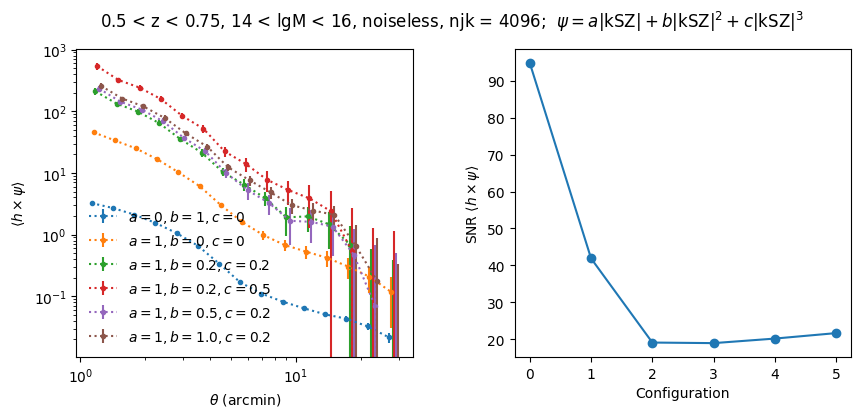

In [22]:
# plot the results
# plot variantons with noise factor. Make a 3 panel plot with left panel showing xi_dy_full2 and center panel showing xi_dy_abs and right panel showing the SNR full2/abs:
import pickle as pk
lgM_min = 14.0
lgM_max = 16.0
zmin = 0.5
zmax = 0.75

lgM_min = 14.0
lgM_max = 16.0

M_min = 10**lgM_min
M_max = 10**lgM_max

z_min = 0.5
z_max = 0.75

a_array = np.array([0.0, 0.0, 0.2, 0.2, 0.5, 1.0])
b_array = np.array([0.0, 0.0, 0.2, 0.5, 0.2, 0.2])

config_all = np.arange(len(a_array))
ldir = '/mnt/home/spandey/ceph/SZST/results/'
# fig, ax_all = pl.subplots(2,1, figsize=(6,13))
fig, ax_all = pl.subplots(1,2, figsize=(10,4))
fig.subplots_adjust(wspace=0.3)

snr_value = np.zeros(len(a_array))
for jz in range(len(a_array)):
    # noise_std_jz = noise_std_level_array[jz] 
    if jz == 0:
        df = pk.load(open(ldir + 'ksz_noiseless_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
        ax_all[0].errorbar(1.02**jz * df['r_dy_abs'], df['xi_dy_full_abs'], yerr=df['sig_dy_abs'], ms=3.0, ls=':', marker='o', label=r'$a=0, b=1, c=0$')
        snr_value[jz] = df['snr_abs']
    elif jz == 1:
        df = pk.load(open(ldir + 'ksz_noiseless_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
        ax_all[0].errorbar(1.02**jz * df['r_dy2'], df['xi_dy_full2'], yerr=df['sig_dy2'], ls=':', ms=3.0, marker='o', label=r'$a=1, b=0, c=0$')
        snr_value[jz] = df['snr_sq']    
    else:   
        av = a_array[jz]
        bv = b_array[jz]     
        df = pk.load(open(ldir + 'ksz_noiseless_comb_a_' + str(av) + '_b_' + str(bv) + '_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
        ax_all[0].errorbar(1.02**jz * df['r_dy'], df['xi_dy_full'], yerr=df['sig_dy'], ls=':', ms=3.0, marker='o', label=r'$a=1, b=$' + str(av) + '$, c=$' + str(bv))
        snr_value[jz] = df['snr_orig']
    
    ax_all[0].set_xscale('log')
    # ax_all[1].set_xscale('log')
    ax_all[0].set_yscale('log')
    # ax_all[1].set_yscale('log')
    ax_all[0].set_xlabel(r'$\theta$ (arcmin)')
    # ax_all[1].set_xlabel(r'$\theta$ (arcmin)')
    ax_all[0].set_ylabel(r'$\langle h \times \psi \rangle$')
    # ax_all[1].set_ylabel(r'$\langle h \times |{\rm kSZ}| \rangle$')
ax_all[0].legend(frameon=False)
fig.suptitle('0.5 < z < 0.75, 14 < lgM < 16, noiseless, njk = 4096;  '+ r'$\psi = a|{\rm kSZ}| + b|{\rm kSZ}|^2 + c|{\rm kSZ}|^3$')
ax_all[1].plot(config_all, snr_value, 'o-')
ax_all[1].set_xlabel(r'Configuration')
# ax_all[1].set_xscale('log')
ax_all[1].set_ylabel(r'SNR $\langle h \times \psi\rangle$')
fig.savefig('/mnt/home/spandey/ceph/SZST/results/COMB_VARY_ksz_xi_results_njk_4096_dict_lgM_14_16_z_0.5_0.75.png', bbox_inches='tight')




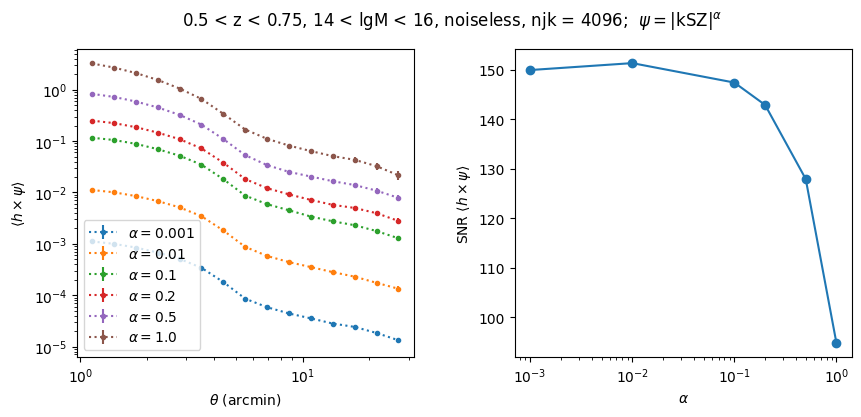

In [24]:
# plot the results
# plot variantons with noise factor. Make a 3 panel plot with left panel showing xi_dy_full2 and center panel showing xi_dy_abs and right panel showing the SNR full2/abs:
import pickle as pk
lgM_min = 14.0
lgM_max = 16.0
zmin = 0.5
zmax = 0.75

lgM_min = 14.0
lgM_max = 16.0

M_min = 10**lgM_min
M_max = 10**lgM_max

z_min = 0.5
z_max = 0.75

pow_array = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0])

# config_all = np.arange(len(a_array))
ldir = '/mnt/home/spandey/ceph/SZST/results/'
# fig, ax_all = pl.subplots(2,1, figsize=(6,13))
fig, ax_all = pl.subplots(1,2, figsize=(10,4))
fig.subplots_adjust(wspace=0.3)

snr_value = np.zeros(len(pow_array))
for jz in range(len(pow_array)):
    pow_ja = pow_array[jz]
    if pow_ja == 1.0:
        df = pk.load(open(ldir + 'ksz_noiseless_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
        ax_all[0].errorbar(df['r_dy_abs'], df['xi_dy_full_abs'], yerr=df['sig_dy_abs'], ms=3.0, ls=':', marker='o', label=r'$\alpha=$' + str(pow_ja))
        snr_value[jz] = df['snr_abs']
    else:
        df = pk.load(open(ldir + 'ksz_noiseless_abspow_' + str(pow_ja) + '_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
        ax_all[0].errorbar(df['r_dy'], df['xi_dy_full'], yerr=df['sig_dy'], ls=':', ms=3.0, marker='o', label=r'$\alpha=$' + str(pow_ja))
        snr_value[jz] = df['snr_orig']
    
    ax_all[0].set_xscale('log')
    # ax_all[1].set_xscale('log')
    ax_all[0].set_yscale('log')
    # ax_all[1].set_yscale('log')
    ax_all[0].set_xlabel(r'$\theta$ (arcmin)')
    # ax_all[1].set_xlabel(r'$\theta$ (arcmin)')
    ax_all[0].set_ylabel(r'$\langle h \times \psi \rangle$')
    # ax_all[1].set_ylabel(r'$\langle h \times |{\rm kSZ}| \rangle$')
ax_all[0].legend(frameon=True)
fig.suptitle('0.5 < z < 0.75, 14 < lgM < 16, noiseless, njk = 4096;  ' +  r'$\psi = |{\rm kSZ}|^{\alpha}$')
ax_all[1].plot(pow_array, snr_value, 'o-')
ax_all[1].set_xlabel(r'$\alpha$')
ax_all[1].set_xscale('log')
ax_all[1].set_ylabel(r'SNR $\langle h \times \psi\rangle$')
fig.savefig('/mnt/home/spandey/ceph/SZST/results/POW_VARY_ksz_xi_results_njk_4096_dict_lgM_14_16_z_0.5_0.75.png', bbox_inches='tight')




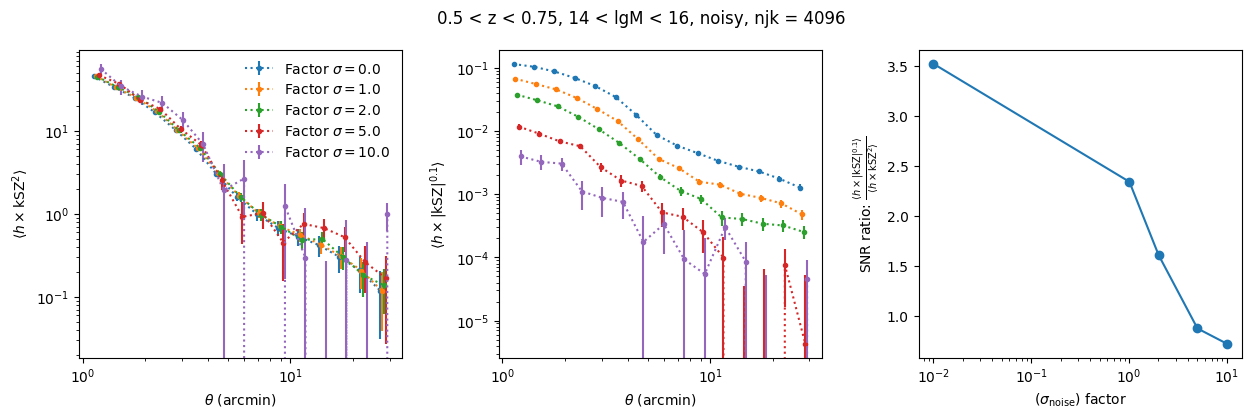

In [26]:
# plot the results
# plot variantons with noise factor. Make a 3 panel plot with left panel showing xi_dy_full2 and center panel showing xi_dy_abs and right panel showing the SNR full2/abs:
import pickle as pk
lgM_min = 14.0
lgM_max = 16.0
zmin = 0.5
zmax = 0.75

noise_std_level_array = np.array([0.0, 1.0, 2.0, 5.0, 10.0])
lgM_cen_array = (lgM_min_array + lgM_min_array)/2.0
ldir = '/mnt/home/spandey/ceph/SZST/results/'
# fig, ax_all = pl.subplots(3,1, figsize=(6,18))
fig, ax_all = pl.subplots(1,3, figsize=(15,4))
fig.subplots_adjust(wspace=0.3)

snr_ratio = np.zeros(len(noise_std_level_array))
for jz in range(len(noise_std_level_array)):
    noise_std_jz = noise_std_level_array[jz] 
    if jz == 0:
        df = pk.load(open(ldir + 'ksz_noiseless_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
    else:        
        df = pk.load(open(ldir + 'ksz_noisefac_' + str(noise_std_jz) + 'sigma_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
    ax_all[0].errorbar(1.02**jz * df['r_dy2'], df['xi_dy_full2'], yerr=df['sig_dy2'], ls=':', ms=3.0, marker='o', label=r'Factor $\sigma = $' + str(noise_std_jz))
    
    
    if jz == 0:
        df2 = pk.load(open(ldir + 'ksz_noiseless_abspow_0.1_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
    else:        
        df2 = pk.load(open(ldir + 'ksz_abspow_0.1_noisefac_' + str(noise_std_jz) + 'sigma_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
    ax_all[1].errorbar(1.02**jz * df2['r_dy'], df2['xi_dy_full'], yerr=df2['sig_dy'], ls=':', ms=3.0, marker='o', label=r'Factor $\sigma = $' + str(noise_std_jz))
    
    # ax_all[1].errorbar(1.02**jz * df['r_dy_abs'], df['xi_dy_full_abs'], yerr=df['sig_dy_abs'], ms=3.0, ls=':', marker='o', label=r'Factor $\sigma = $' + str(noise_std_jz))
    snr_ratio[jz] = df2['snr_orig']/df['snr_sq']
    ax_all[0].set_xscale('log')
    ax_all[1].set_xscale('log')
    ax_all[0].set_yscale('log')
    ax_all[1].set_yscale('log')
    ax_all[0].set_xlabel(r'$\theta$ (arcmin)')
    ax_all[1].set_xlabel(r'$\theta$ (arcmin)')
    ax_all[0].set_ylabel(r'$\langle h \times {\rm kSZ}^2 \rangle$')
    ax_all[1].set_ylabel(r'$\langle h \times |{\rm kSZ}|^{0.1} \rangle$')
ax_all[0].legend(frameon=False)
fig.suptitle('0.5 < z < 0.75, 14 < lgM < 16, noisy, njk = 4096')
ax_all[2].plot(noise_std_level_array+1e-2, snr_ratio, 'o-')
ax_all[2].set_xlabel(r'$(\sigma_{\rm noise})$ factor')
ax_all[2].set_xscale('log')
ax_all[2].set_ylabel(r'SNR ratio: $\frac{\langle h \times |{\rm kSZ}|^{0.1} \rangle}{\langle h \times {\rm kSZ}^2 \rangle}$')
fig.savefig('/mnt/home/spandey/ceph/SZST/results/POW_0.1_NOISE_VARY_ksz_xi_results_njk_4096_dict_lgM_14_16_z_0.5_0.75.png', bbox_inches='tight')




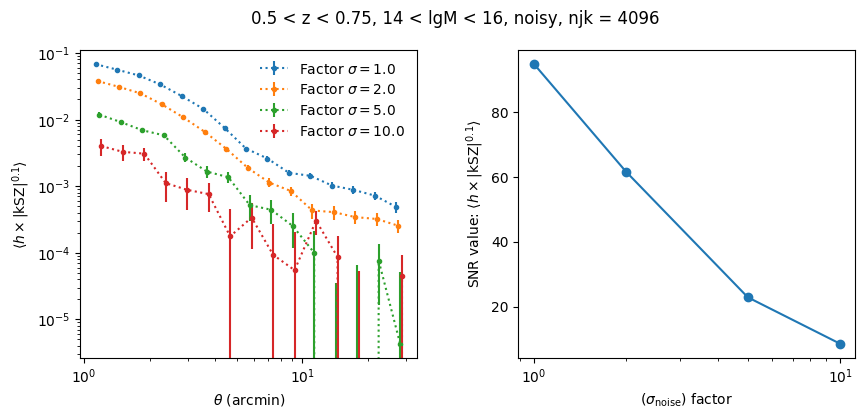

In [33]:
# plot the results
# plot variantons with noise factor. Make a 3 panel plot with left panel showing xi_dy_full2 and center panel showing xi_dy_abs and right panel showing the SNR full2/abs:
import pickle as pk
lgM_min = 14.0
lgM_max = 16.0
zmin = 0.5
zmax = 0.75
pow_ja = 0.1

noise_std_level_array = np.array([1.0, 2.0, 5.0, 10.0])
lgM_cen_array = (lgM_min_array + lgM_min_array)/2.0
ldir = '/mnt/home/spandey/ceph/SZST/results/'
# fig, ax_all = pl.subplots(2,1, figsize=(6,13))
fig, ax_all = pl.subplots(1,2, figsize=(10,4))
fig.subplots_adjust(wspace=0.3)

snr_value = np.zeros(len(noise_std_level_array))
for jz in range(len(noise_std_level_array)):
    noise_std_jz = noise_std_level_array[jz] 
    # if jz == 0:
    #     df = pk.load(open(ldir + 'ksz_noiseless_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
    # else:        
    # df = pk.load(open(ldir + 'ksz_noisefac_' + str(noise_std_jz) + 'sigma_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
    # ax_all[0].errorbar(1.02**jz * df['r_dy2'], df['xi_dy_full2'], yerr=df['sig_dy2'], ls=':', ms=3.0, marker='o', label=r'Factor $\sigma = $' + str(noise_std_jz))
        
    # if jz == 0:
    #     df2 = pk.load(open(ldir + 'ksz_noiseless_abspow_0.1_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
    # else:        
    df2 = pk.load(open(ldir + 'ksz_abspow_' + str(pow_ja) + '_noisefac_' + str(noise_std_jz) + 'sigma_xi_results_njk_4096_dict_z_' + str(zmin) + '_' + str(zmax) + '_lgM_' + str(lgM_min) + '_' + str(lgM_max) + '.pk','rb')) 
    ax_all[0].errorbar(1.02**jz * df2['r_dy'], df2['xi_dy_full'], yerr=df2['sig_dy'], ls=':', ms=3.0, marker='o', label=r'Factor $\sigma = $' + str(noise_std_jz))
    
    # ax_all[1].errorbar(1.02**jz * df['r_dy_abs'], df['xi_dy_full_abs'], yerr=df['sig_dy_abs'], ms=3.0, ls=':', marker='o', label=r'Factor $\sigma = $' + str(noise_std_jz))
    snr_value[jz] = df2['snr_orig']
    ax_all[0].set_xscale('log')
    # ax_all[1].set_xscale('log')
    ax_all[0].set_yscale('log')
    # ax_all[1].set_yscale('log')
    ax_all[0].set_xlabel(r'$\theta$ (arcmin)')
    # ax_all[1].set_xlabel(r'$\theta$ (arcmin)')
    ax_all[0].set_ylabel(r'$\langle h \times |{\rm kSZ}|^{0.1} \rangle$')
    # ax_all[1].set_ylabel(r'$\langle h \times |{\rm kSZ}|^{0.1} \rangle$')
ax_all[0].legend(frameon=False)
fig.suptitle('0.5 < z < 0.75, 14 < lgM < 16, noisy, njk = 4096')
ax_all[1].plot(noise_std_level_array, snr_value, 'o-')
ax_all[1].set_xlabel(r'$(\sigma_{\rm noise})$ factor')
ax_all[1].set_xscale('log')
ax_all[1].set_ylabel(r'SNR value: $\langle h \times |{\rm kSZ}|^{0.1} \rangle$')
fig.savefig('/mnt/home/spandey/ceph/SZST/results/VARY_POW_' + str(pow_ja) + '_NOISE_VARY_ksz_xi_results_njk_4096_dict_lgM_14_16_z_0.5_0.75.png', bbox_inches='tight')




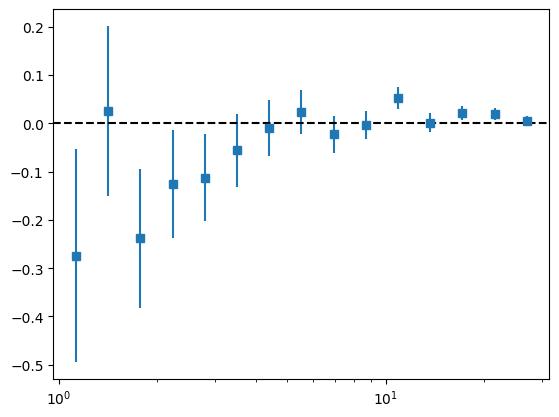

In [60]:
# xi_dy_full_abs
pl.figure()
pl.errorbar(r_dy, xi_dy_full, sig_dy, ls='', marker='s')
pl.axhline(0, ls='--', color='k')
# pl.errorbar(r_dy_abs*1.05, xi_dy_full2, sig_dy2, ls='', marker='o')
pl.xscale('log')
# pl.yscale('log')




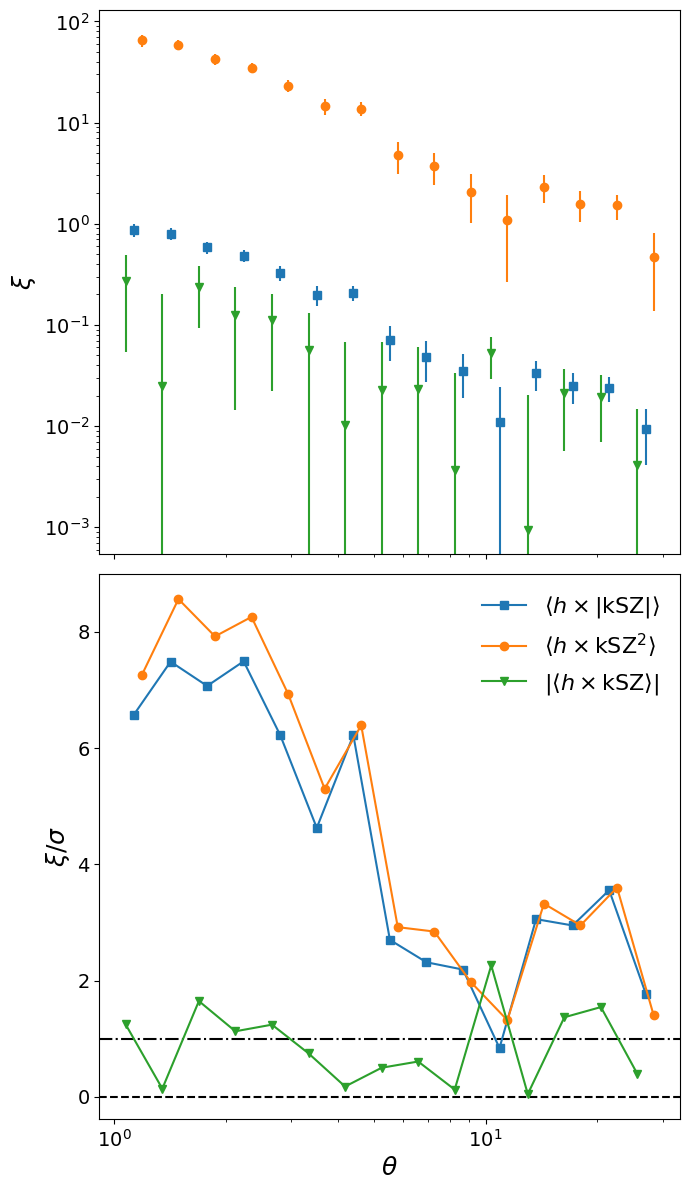

In [65]:
import matplotlib.pyplot as plt

# create the first subplot
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(7, 12))
plt.subplots_adjust(hspace=0.05)
ax1.errorbar(r_dy_abs, xi_dy_full_abs, sig_dy_abs, ls='', marker='s', label=r'$\langle h \times |\rm{kSZ}| \rangle$')
ax1.errorbar(r_dy_abs*1.05, xi_dy_full2, sig_dy2, ls='', marker='o', label=r'$\langle h  \times \rm{kSZ}^2 \rangle$')
ax1.errorbar(0.95*r_dy, np.abs(xi_dy_full), sig_dy, ls='', marker='v', label=r'$|\langle h  \times \rm{kSZ} \rangle|$')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.tick_params(axis='both', labelsize=14)
# ax1.legend(fontsize=16, frameon=False)
ax1.set_ylabel(r'$\xi$', size=18)

# create the second subplot
ax2.errorbar(r_dy_abs, xi_dy_full_abs/sig_dy_abs, ls='-', marker='s', label=r'$\langle h \times |\rm{kSZ}| \rangle$')
ax2.errorbar(r_dy_abs*1.05, xi_dy_full2/sig_dy2, ls='-', marker='o', label=r'$\langle h  \times \rm{kSZ}^2 \rangle$')
ax2.errorbar(0.95*r_dy, np.abs(xi_dy_full)/sig_dy, ls='-', marker='v', label=r'$|\langle h  \times \rm{kSZ} \rangle|$')
ax2.axhline(0.0, ls='--', color='k')
ax2.axhline(1.0, ls='-.', color='k')
ax2.set_xscale('log')
ax2.tick_params(axis='both', labelsize=14)
ax2.legend(fontsize=16, frameon=False)
ax2.set_xlabel(r'$\theta$', size=18)
ax2.set_ylabel(r'$\xi/\sigma$', size=18)

# display the plot
# plt.show()
plt.tight_layout()
# plt.savefig('ksz_yuuki_cross_halos_Mgt_' + '1e14' + '_zlt_0p5' + '_noiseless.pdf')
# plt.savefig('ksz_yuuki_cross_halos_Mgt_' + '1e14' + '_zlt_0p5' + '_10signoise.pdf')
# plt.savefig('ksz_cross_halos_Mgt_' + '1e14' + '_zlt_0p5' + '_websky.pdf')




In [69]:
def get_corr(cov):
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v, v)
    corr = cov / outer_v
    return corr


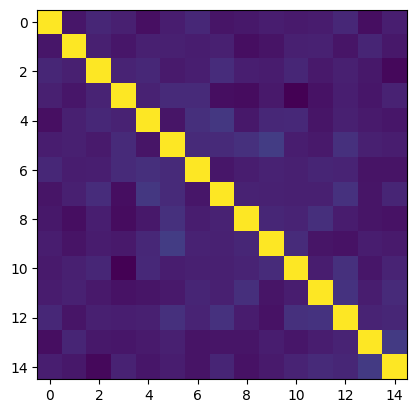

In [70]:
pl.figure()
# pl.imshow(np.log(np.abs(cov_dy2)))
pl.imshow(get_corr(cov_dy2))


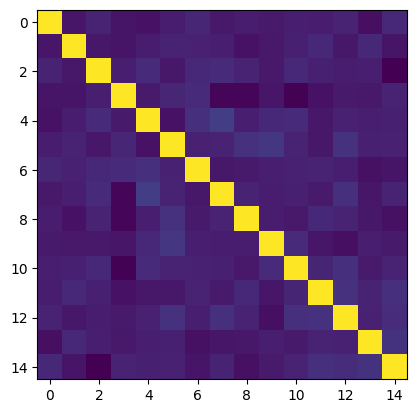

In [71]:
pl.figure()
# pl.imshow(np.log(np.abs(cov_dy_abs)))
pl.imshow(get_corr(cov_dy_abs))


In [32]:
nestpix = hp.ang2pix(2048,datapoint_ra, datapoint_dec,nest=True,lonlat=True)
pix = nestpix
pix.sort()
first = np.where(pix[:-1] != pix[1:])[0] + 1
first = np.concatenate(([0],first))
hpix = pix[first]
cts = np.diff(first,append=len(pix))
m = np.zeros(hp.nside2npix(2048),dtype=int)
m[hpix] = cts
density_halo = -1 + m/np.mean(m)
density_halo = hp.reorder(density_halo, n2r=True)


In [49]:
# hp.mollview(np.log(1.001 + density_halo), nest=True)
hp.write_map('takahashi_density_halo_Mgt_5e13_zlt_0p5_ns2048.fits', density_halo)



setting the output map dtype to [dtype('float64')]


In [50]:
hp.write_map('takahashi_ksz_wnoise_3sigma_ns2048.fits', ksz)



setting the output map dtype to [dtype('float64')]


In [37]:
Cls_ksz_h = hp.anafast(density_halo, ksz)
Cls_absksz_h = hp.anafast(density_halo, np.abs(ksz))
Cls_ksz2_h = hp.anafast(density_halo, (ksz)**2)
ells = np.arange(len(Cls_ksz_h))




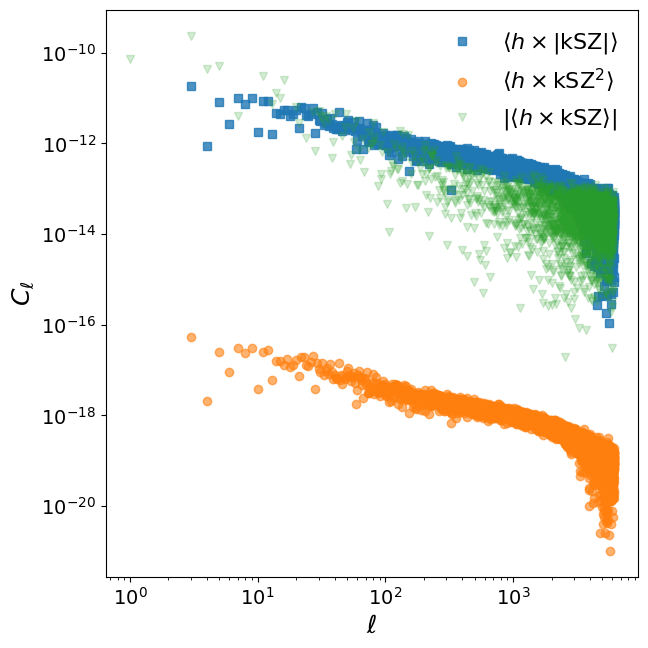

In [47]:
pl.figure()
pl.plot(ells, Cls_absksz_h, ls='', alpha=0.8, marker='s', label=r'$\langle h \times |\rm{kSZ}| \rangle$')
pl.plot(ells, Cls_ksz2_h, ls='', alpha=0.6, marker='o', label=r'$\langle h  \times \rm{kSZ}^2 \rangle$')
pl.plot(ells, Cls_ksz_h, ls='', alpha=0.2, marker='v', label=r'$|\langle h  \times \rm{kSZ} \rangle|$')
pl.xscale('log')
pl.yscale('log')
# pl.set_xscale('log')
# pl.set_yscale('log')
pl.tick_params(axis='both', labelsize=14)
pl.legend(fontsize=16, frameon=False)
pl.ylabel(r'$C_{\ell}$', size=18)
pl.xlabel(r'${\ell}$', size=18)
# pl.ylim(1e-6, 1e-3)
pl.tight_layout()
pl.savefig('harmonic_ksz_cross_halos_Mgt_' + '5e13' + '_zlt_0p5' + '_3signoise.pdf')



(1e-06, 0.001)

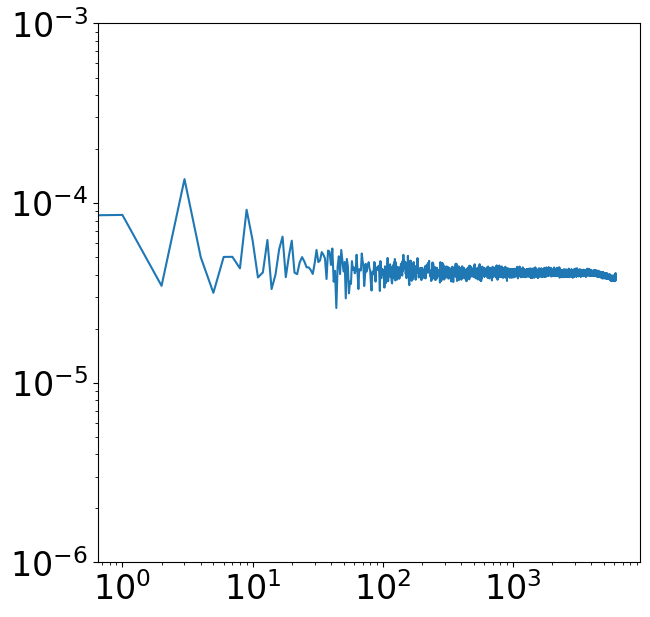

In [47]:
pl.figure()
pl.plot(ells, Cls)
pl.xscale('log')
pl.yscale('log')
pl.ylim(1e-6, 1e-3)



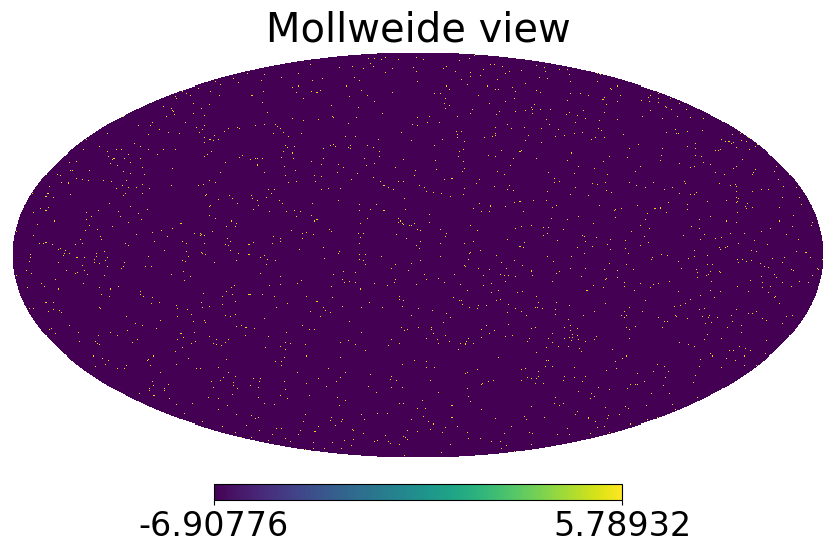

findfont: Generic family 'serif' not found because none of the following families were found: Palatino
findfont: Generic family 'serif' not found because none of the following families were found: Palatino


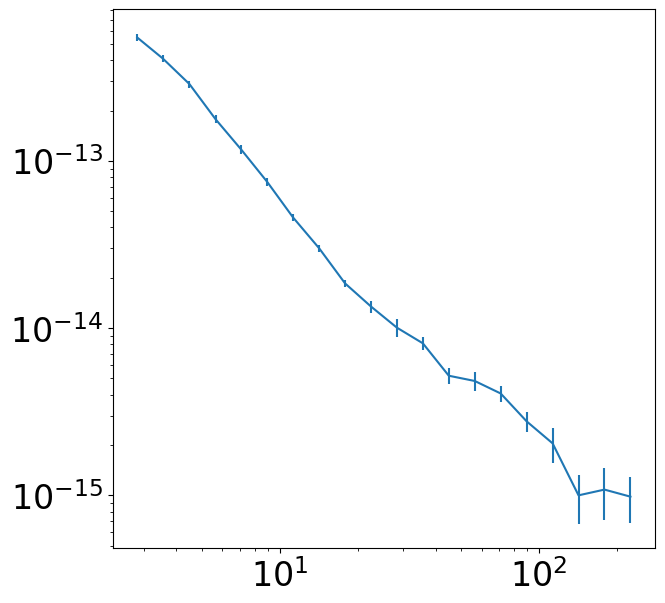

In [47]:
# xi_dy_full_abs
pl.figure()
pl.errorbar(r_dy_abs, xi_dy_full2, sig_dy2)
pl.xscale('log')
pl.yscale('log')




In [48]:
# df = hp.read_map('/global/cfs/cdirs/lsst/www/shivamp/ksz_test/allsky_HP_kSZ_nres13_r000.fits')
# ksz = hp.ud_grade(df, 1024)
# # print(hp.npix2nside(len(df)))
# # hp.mollview(np.log(np.abs(df_ud)))



129602594


30185


In [6]:
datapoint_ra, datapoint_dec = ang2eq(theta_i[indsel], phi_i[indsel])
datapoint_w = np.ones_like(datapoint_ra)
nrand = 10*len(datapoint_ra)
rand_ra, rand_dec = esutil.coords.randsphere(nrand, ra_range=[0,360], dec_range=[-90,90])
rand_theta, rand_phi = eq2ang(rand_ra, rand_dec)
rand_w = np.ones_like(rand_ra)




In [9]:
# ra_y, dec_y, ymap_truth = np.array(rad2deg * ras.flatten()), np.array(rad2deg * decs.flatten()), np.array(imapy.flatten())    
ytruth_cat = treecorr.Catalog(ra=pix_ra, dec=pix_dec, k=ksz, ra_units='degrees', dec_units='degrees')

dytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')
randytruth = treecorr.NKCorrelation(nbins=nrad, min_sep=minrad, max_sep=maxrad, sep_units='arcmin', verbose=0,num_threads=nthreads, bin_slop=bin_slop, var_method='jackknife')

print('doing dataxy calculation')
dytruth.process(datapoint_cat, ytruth_cat)

print('doing randomxy calculation')
randytruth.process(rand_cat, ytruth_cat)
dytruth.calculateXi(rk=randytruth)

xi_dy_full = dytruth.xi
r_dy = np.exp(dytruth.meanlogr)
cov_dy = dytruth.cov
sig_dy = np.sqrt(np.diag(cov_dy))
print(xi_dy_full)




NameError: name 'pix_ra' is not defined

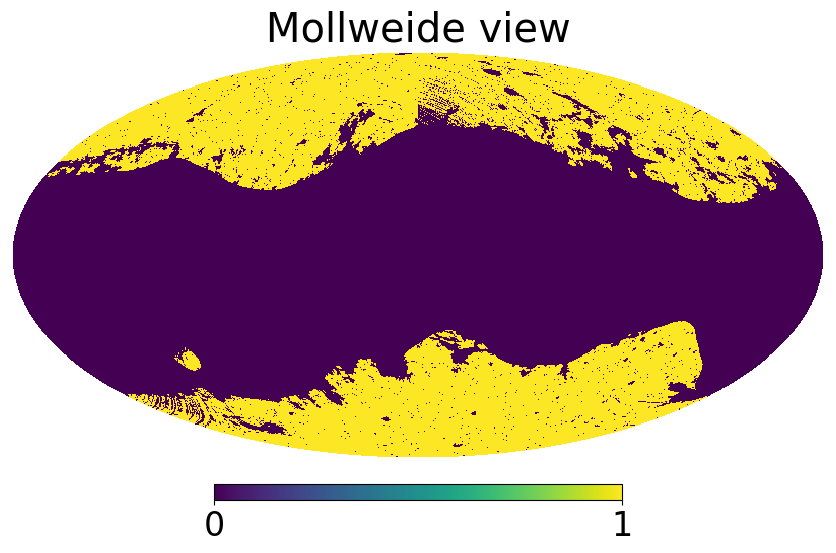

In [1]:
# More specifically, we recommend using
# thresholds of 2.5×1020 cm−2 (353 GHz), 2.0×1020 cm−2 (545
# GHz), and 1.8×1020 cm−2 (857 GHz)
import healpy as hp
from astropy.io import fits
import numpy as np
import treecorr
import esutil
# from pixell import utils, bunch
# import numpy as np, pyccl, time
# import pyccl
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
pl.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans"
})



# 353
df = hp.read_map('/global/cfs/cdirs/des/shivamp/ACTxDESY3_data/planck_data/lenz17/545/mask_bool.fits')
hp.mollview(df)
# hp.npix2nside(len(df))



In [2]:
r = hp.Rotator(coord=['G','C'])
df_rotated = r.rotate_map_alms(df)



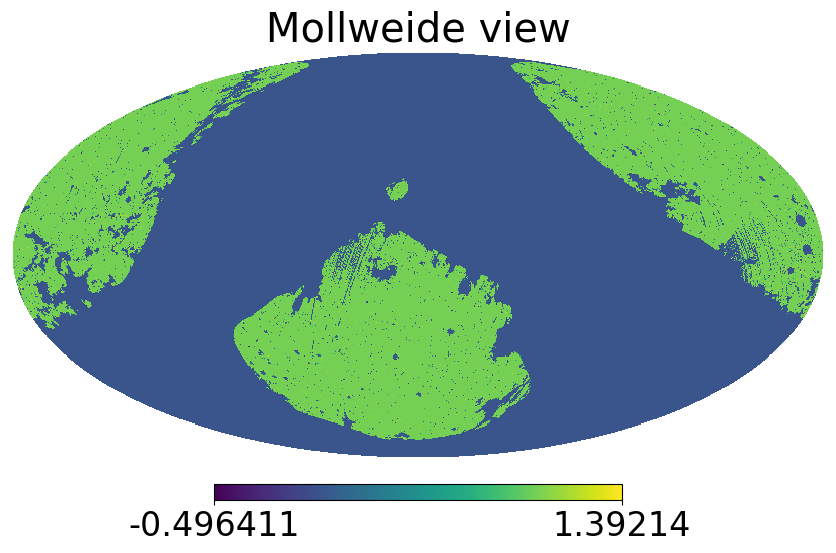

In [3]:
hp.mollview(df_rotated)



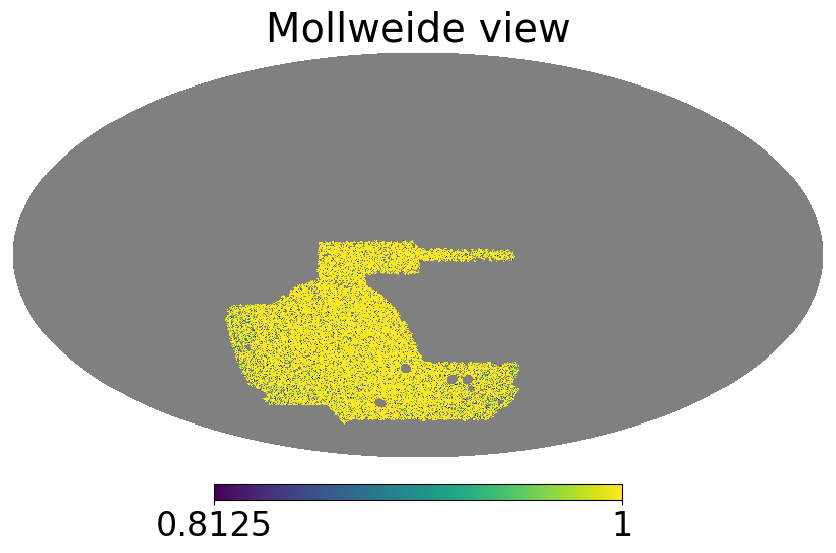

In [17]:
mask_des = hp.read_map('/global/cfs/cdirs/des/data_actxdes/des_data/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask.fits.gz', partial=True)
hp.mollview(mask_des)



In [8]:
indsel = np.where(df_rotated > 0.1)[0]
df_rotated[indsel] = 1.

indsel = np.where(df_rotated < 0.1)[0]
df_rotated[indsel] = 0.



In [19]:
# mask_des = hp.ud_grade(mask_des, 2048)

# indsel = np.where(mask_des > 0.1)[0]
# mask_des[indsel] = 1.

# indsel = np.where(mask_des < 0.1)[0]
# mask_des[indsel] = 0.



In [23]:
mask_f = hp.read_map('/global/cfs/cdirs/des/data_actxdes/mask_updated_ACTDR6xDESY3.fits')
# nside = 2048
nside = 4096

mask_des = hp.ud_grade(mask_f, 2048)

indsel = np.where(mask_des > 0.1)[0]
mask_des[indsel] = 1.

indsel = np.where(mask_des < 0.1)[0]
mask_des[indsel] = 0.


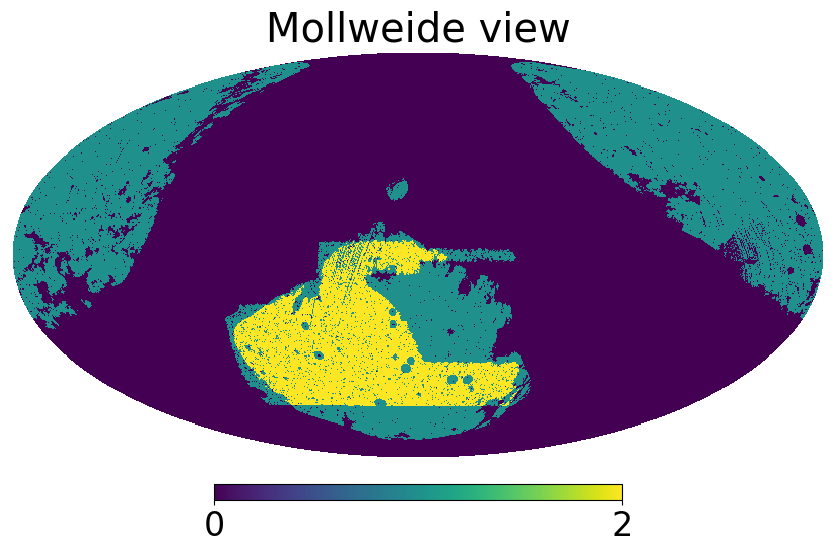

In [24]:
hp.mollview(df_rotated+mask_des)



In [25]:
indsel = np.where(df_rotated+mask_des == 2)[0]



In [26]:
print(len(indsel) * hp.nside2pixarea(2048, degrees=True))



3516.269084351507


In [14]:
hp.nside2pixarea(2048, degrees=True)*(60**2)


2.9506417214455083